In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
# from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_dir = '/content/drive/MyDrive/'
!ls '/content/drive/MyDrive/'

 Capstone	    Dataset		       'Open Drive'		       tambahan
 coba		   'Dokumen tanpa judul.gdoc'  'Redo Hariyadi XII IPA 2.jpg'
'Colab Notebooks'   Inceptionv3		        rempahpedia


In [ ]:
root_dir = "./"
test_dir = base_dir + "testing/"
train_dir = base_dir + "training/"
work_dir = root_dir + "Inceptionv3"

# if os.path.exists(work_dir):
#     remove_tree(work_dir)


# os.mkdir(work_dir)
# copy_tree(train_dir, work_dir)
# copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['mantap.jpg', 'WhatsApp Image 2024-05-26 at 11.03.28.jpeg', 'WhatsApp Image 2024-05-26 at 11.04.05.jpeg', 'apa ini.jpg', 'Kemiri', 'WhatsApp Image 2024-05-26 at 11.03.28 (1).jpeg', 'Lengkuas', 'WhatsApp Image 2024-06-01 at 11.10.47.jpeg', 'Kencur', 'WhatsApp Image 2024-06-01 at 11.13.43.jpeg', 'Cengkeh', 'Bunga Lawang', 'Jahe', 'Ketumbar', 'Kunyit', 'Pala', 'WhatsApp Image 2024-05-26 at 11.04.40.jpeg', 'Kayu Manis']


In [ ]:
WORK_DIR = './Inceptionv3/'

CLASSES = ['Kemiri',
           'Lengkuas',
            'Kencur',
            'Cengkeh',
            'Bunga Lawang',
            'Jahe',
            'Ketumbar',
            'Kunyit',
            'Pala',
            'Kayu Manis']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=4900, shuffle=False)

Found 4837 images belonging to 10 classes.


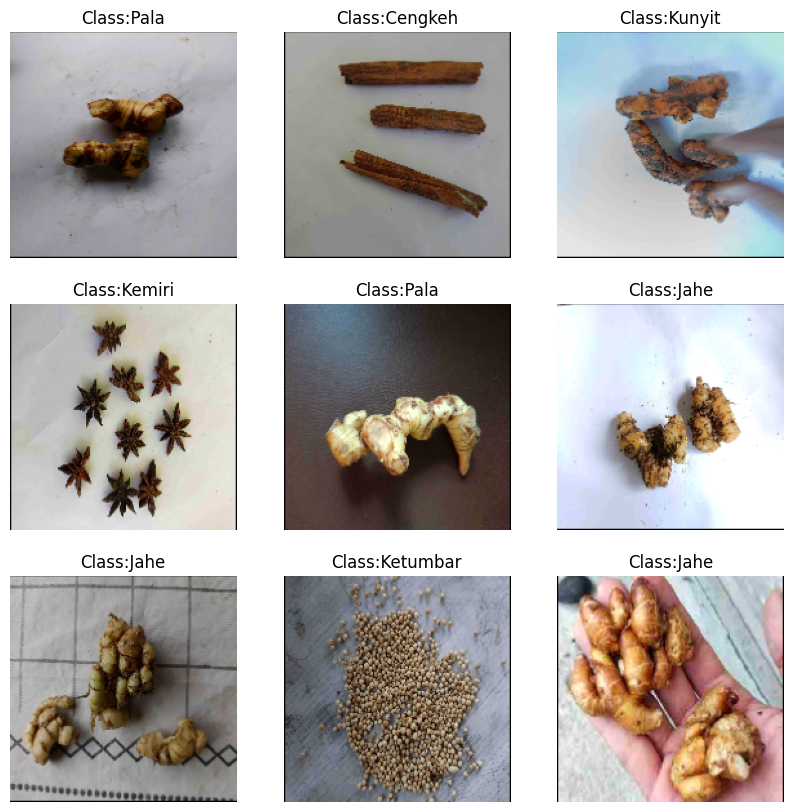

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """

    # get image lables
    labels =dict(zip([0,1,2,3,4,5,6,7,8,9], CLASSES))

    # get a batch of images
    x,y = generator.next()

    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 4837)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# Display Train Images
show_images(train_data_gen)

In [ ]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [ ]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(4837, 176, 176, 3) (4837, 10)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(5740, 176, 176, 3) (5740, 10)


In [ ]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

In [ ]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ], name = "inception_cnn_model")

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=10)]

CALLBACKS = [my_callback, rop_callback]

custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout_5 (Dropout)         (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_99 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 512)       

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
115/115 [==============================] - 352s 3s/step - loss: 1.8426 - acc: 0.3945 - auc: 0.7867 - f1_score: 0.3878 - val_loss: 0.5779 - val_acc: 0.8248 - val_auc: 0.9835 - val_f1_score: 0.8189 - lr: 0.0010
Epoch 2/100
115/115 [==============================] - 342s 3s/step - loss: 0.9186 - acc: 0.7196 - auc: 0.9544 - f1_score: 0.7164 - val_loss: 0.2743 - val_acc: 0.9075 - val_auc: 0.9959 - val_f1_score: 0.9060 - lr: 0.0010
Epoch 3/100
115/115 [==============================] - 321s 3s/step - loss: 0.5759 - acc: 0.8361 - auc: 0.9819 - f1_score: 0.8363 - val_loss: 0.1789 - val_acc: 0.9434 - val_auc: 0.9965 - val_f1_score: 0.9433 - lr: 0.0010
Epoch 4/100
115/115 [==============================] - 342s 3s/step - loss: 0.4333 - acc: 0.8900 - auc: 0.9887 - f1_score: 0.8900 - val_loss: 0.1469 - val_acc: 0.9521 - val_auc: 0.9972 - val_f1_score: 0.9518 - lr: 0.0010
Epoch 5/100
115/115 [==============================] - 342s 3s/step - loss: 0.3342 - acc: 0.9140 - auc: 0.9930 - f1_

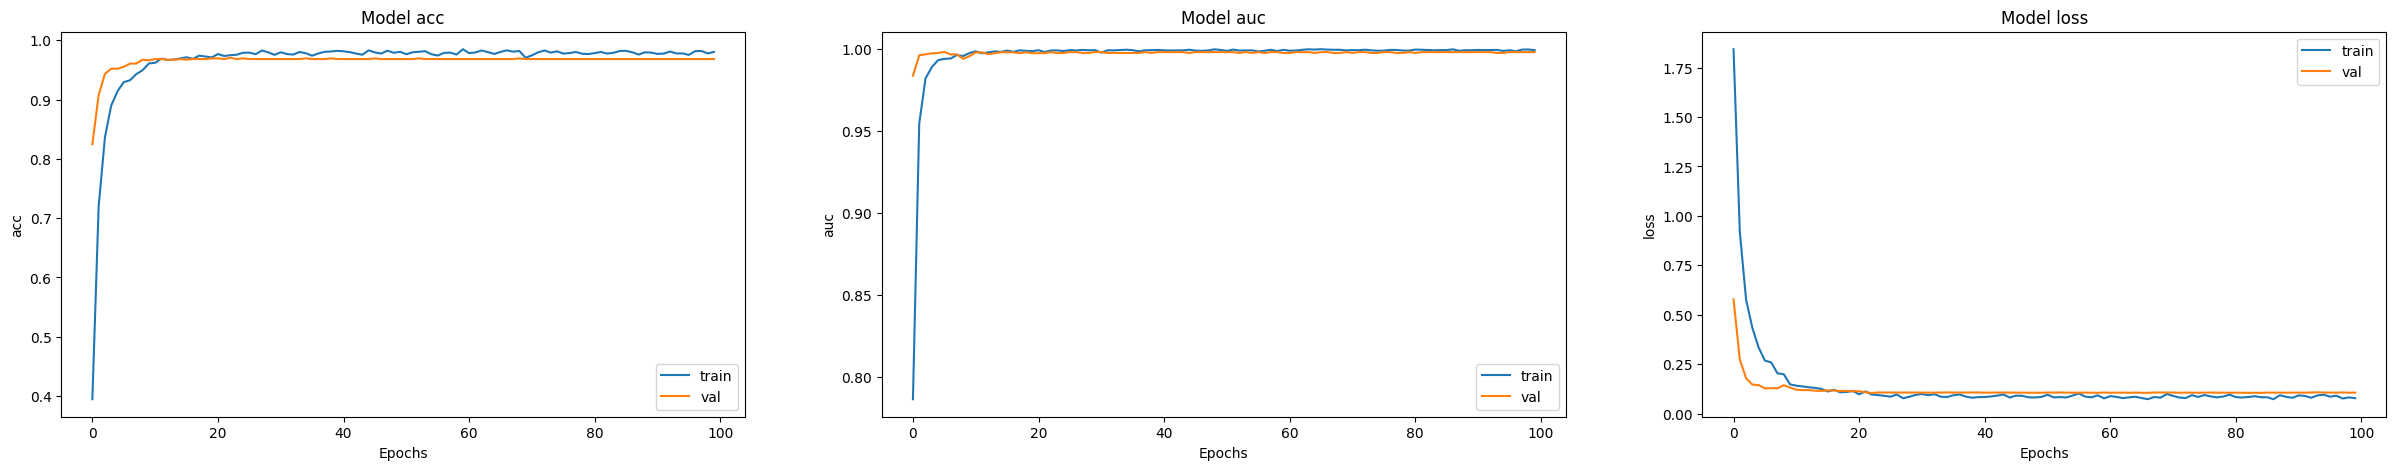

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

36/36 [==============================] - 76s 2s/step - loss: 0.0582 - acc: 0.9852 - auc: 0.9980 - f1_score: 0.9847
Testing Accuracy: 98.52%


In [ ]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

36/36 [==============================] - 81s 2s/step


In [ ]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

      Kemiri       0.99      1.00      1.00       131
    Lengkuas       1.00      0.98      0.99       120
      Kencur       0.96      0.98      0.97       104
     Cengkeh       0.98      1.00      0.99       114
Bunga Lawang       0.99      0.97      0.98       118
        Jahe       0.97      0.97      0.97       118
    Ketumbar       0.98      1.00      0.99       104
      Kunyit       1.00      0.98      0.99       124
        Pala       0.98      0.97      0.97        97
  Kayu Manis       0.99      0.99      0.99       118

   micro avg       0.99      0.99      0.99      1148
   macro avg       0.98      0.98      0.98      1148
weighted avg       0.99      0.99      0.99      1148
 samples avg       0.99      0.99      0.99      1148



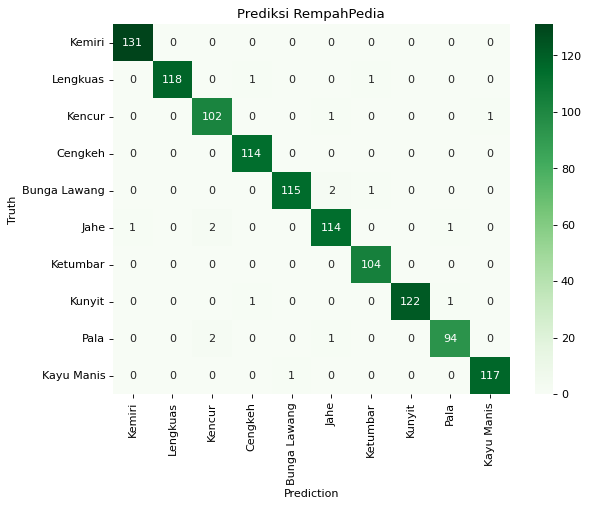

In [ ]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Prediksi RempahPedia')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#Saving the model for future use

custom_inception_model_dir = '/content/drive/MyDrive/rempahpedia/Model' + "rempahpedia_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir('/content/drive/MyDrive/rempahpedia/Model')

['VGG16']

In [ ]:
# Define the directory to save the model
custom_inception_model_dir = '/content/drive/MyDrive/rempahpedia/Model/rempahpedia_inception_cnn_model.h5'

# Create the directory if it does not exist
os.makedirs(os.path.dirname(custom_inception_model_dir), exist_ok=True)

# Save the model
custom_inception_model.save(custom_inception_model_dir, save_format='h5')

# List the directory contents to confirm the save
print(os.listdir('/content/drive/MyDrive/rempahpedia/Model'))

['VGG16', 'rempahpedia_inception_cnn_model.h5']


In [ ]:
!pip install tensorflow pydot
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from tensorflow.keras.utils import plot_model

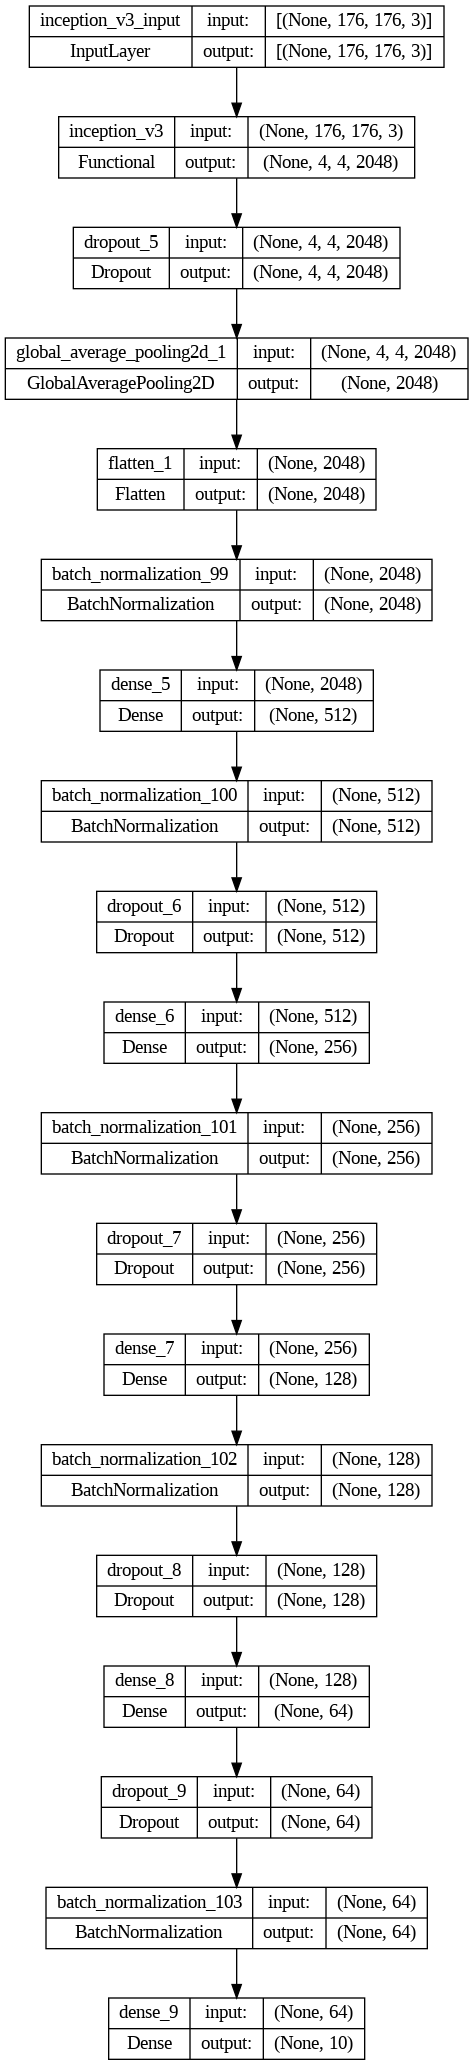

In [ ]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os
from google.colab import files

# Load trained model
model_path = "/content/drive/MyDrive/rempahpedia/Model/rempahpedia_inception_cnn_model.h5"
model = tf.keras.models.load_model(model_path)

# Path to directory containing class labels
train_dir = "/content/drive/MyDrive/rempahpedia/training"
class_list = sorted(os.listdir(train_dir))

# Function to process image and make prediction
def predict_image(img):
    # Preprocess image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize pixel values to match training normalization

    # Perform prediction
    predictions = model.predict(x)

    # Get predicted class label
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_list[predicted_class_index]

    return predicted_class, predictions[0]

# Upload image
uploaded = files.upload()

# Process and predict class label for each uploaded image
for fn in uploaded.keys():
    # Load and preprocess uploaded image
    img = image.load_img(fn, target_size=(176, 176))  # Adjust target size to (176, 176)

    # Predict class label
    predicted_class, confidence_scores = predict_image(img)

    # Display prediction result
    print("Image:", fn)
    print("Predicted Class:", predicted_class)
    print("Confidence Scores:", confidence_scores)
    print()


Saving tumbar.png to tumbar.png
1/1 [==============================] - 2s 2s/step
Image: tumbar.png
Predicted Class: Kemiri
Confidence Scores: [0.01165984 0.00105021 0.00712673 0.02221181 0.52128273 0.02065066
 0.06657083 0.00116333 0.0030138  0.3452701 ]

